In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('large_repr', 'truncate')
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns


from pathlib import Path

from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_curve, roc_auc_score,confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from typing import Tuple

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
sns.set_palette(colours)
%matplotlib inline

In [26]:
import sys
sys.path.insert(0, '../src')
from ds_toolbox import create_balanced_dataset, plot_confusion_matrix_with_labels, compute_metrics, plot_roc_curves_with_classifiers, plot_roc_curves_with_classifier

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
DATA_PATH = Path("../data/")
RANDOM_STATE_PARAMETER = 42
TEST_SIZE = .25

In [7]:
data = pd.read_csv(DATA_PATH / "apld_patients.csv")
data.head()

,PATIENT_ID,Service_date,DIAGNOSIS_CODE,PRC_STD_CD,Blood,Bone,Breast,Heart,Lungs,Medication,Other,Skin,Stomach,Vagina,Season_1,Season_2,Season_3,Season_4,mBC_PATIENT
0,134290358,10/15/2015,C79.81,99214,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
1,134290358,10/15/2015,C79.81,99214,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
2,134290358,10/15/2015,C79.81,99214,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
3,1057559593,11/25/2015,C79.81,85025,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1
4,1057559593,11/25/2015,C79.81,36415,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1


In [ ]:
ohe = pd.get_dummies(data.PRC_STD_CD, prefix="PRC_STD_CD")
data.drop(["PRC_STD_CD"], axis=1, inplace=True)
data = pd.concat([data, ohe], axis=1)

In [8]:
data.columns

Index(['PATIENT_ID', 'Service_date', 'DIAGNOSIS_CODE', 'PRC_STD_CD', 'Blood',
       'Bone', 'Breast', 'Heart', 'Lungs', 'Medication ', 'Other', 'Skin',
       'Stomach', 'Vagina', 'Season_1', 'Season_2', 'Season_3', 'Season_4',
       'mBC_PATIENT'],
      dtype='object')

In [9]:
len(data[data["mBC_PATIENT"] == 0])

66851

In [10]:
len(data[data["mBC_PATIENT"] == 1])

97359

In [12]:
data.iloc[:,4:-1]

,Blood,Bone,Breast,Heart,Lungs,Medication,Other,Skin,Stomach,Vagina,Season_1,Season_2,Season_3,Season_4
0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164205,0,0,0,0,0,0,1,0,0,0,0,0,1,0
164206,0,0,0,0,0,0,1,0,0,0,0,0,1,0
164207,0,0,0,0,0,0,1,0,0,0,0,0,1,0
164208,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [13]:
data.iloc[:,-1]

0         1
1         1
2         1
3         1
4         1
         ..
164205    1
164206    1
164207    1
164208    1
164209    1
Name: mBC_PATIENT, Length: 164210, dtype: int64

In [16]:
x_train, x_test, y_train, y_test = train_test_split(
        data.iloc[:,4:-1],
        data.iloc[:,-1].values,
        random_state = RANDOM_STATE_PARAMETER,
        test_size=TEST_SIZE,
    )            

In [17]:
rf = RandomForestClassifier()      
rf = rf.fit(x_train, y_train)
y_prediction = rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

accuracy:0.6086522300440893, sensitivity:0.8248325181866755, specificity:0.2941035761272575


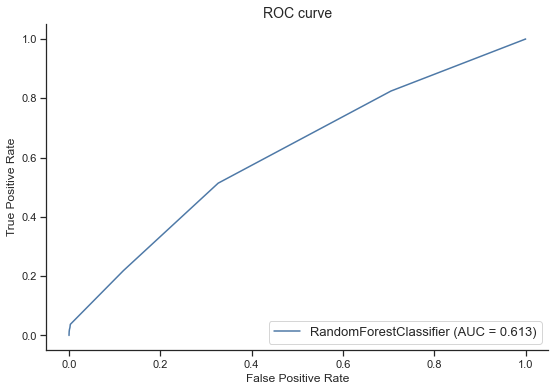

(<Figure size 648x432 with 1 Axes>,
 <AxesSubplot:title={'center':'ROC curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

In [30]:
#models=[logit, svm_linear]
# scores = np.zeros((len(y_test), len(labels)))
# for i, model in enumerate(models):
#     scores[:,i] = model.decision_function(X_test)   
labels=['RandomForestClassifier']
models = [rf]
scores = np.zeros((len(y_test), len(labels)))
for i, model in enumerate(models):
     scores[:,i] = model.predict_proba(x_test)[:,1]   

plot_roc_curves_with_classifiers(scores, y_test, labels)

In [18]:
type(y_prediction)

numpy.ndarray

In [ ]:
plot_confusion_matrix_with_labels(x_test, y_test, rf, ["non_mBC", "mBC"], filename="random_forest_prc_std_cd.pdf")

# Logistic Regression

In [ ]:
%%time
model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[1e-4,1e-3,1e-2,0.1,1],
    "max_iter": [2000, 3000, 4000, 5000]
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(x_train, y_train)
print('Best parameters:', lr_search.best_params_)
best_lr_model = lr_search.best_estimator_
y_prediction = best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

In [ ]:
plot_confusion_matrix_with_labels(x_test, y_test, best_lr_model, ["non_mBC", "mBC"], filename="logistic_reg_prc_std_cd.pdf")

In [ ]:
models = [best_lr_model, rf]
plot_roc_curves_with_classifiers(scores, y_test, labels);
scores = np.zeros((len(y_test), len(models)))
for i, model in enumerate(models):
    scores[:,i] = model.predict_proba(x_test)[:,1]   
plot_roc_curves_with_classifiers(scores, y_test, labels);

In [22]:
xgb = XGBClassifier(random_state = RANDOM_STATE_PARAMETER, n_jobs = -1)
xgb.fit(x_train, y_train)
y_prediction = xgb.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")
plot_confusion_matrix_with_labels(x_test, y_test, xgb, ["non_mBC", "mBC"], filename="xgb_prc_std_cd.pdf")

KeyboardInterrupt: 

In [ ]:
mbc_ratio=y_train[y_train == 1].shape[0]/y_train[y_train == 0].shape[0]
mbc_ratio

# Logistic Regression on oversampled data

In [ ]:
X_sampled, y_sampled = create_balanced_dataset('SMOTE', x_train, y_train)

In [ ]:
X_sampled.head()

# Random Forest on oversampled data

In [ ]:
oversampling_rf = RandomForestClassifier()      
oversampling_rf = oversampling_rf.fit(X_sampled, y_sampled)
y_prediction = oversampling_rf.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

In [ ]:
oversampling_xgb = XGBClassifier(random_state = RANDOM_STATE_PARAMETER, n_jobs = -1)
oversampling_xgb.fit(X_sampled, y_sampled)
y_prediction = oversampling_xgb.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")

In [ ]:
%%time
model = LogisticRegression()
#model = LogisticRegression(class_weight='balanced')
tuning_parameters = {
    'C':[2, 5, 10],
    "max_iter": [2000, 3000, 4000, 5000]
}

lr_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 5, n_jobs=4,
                              random_state = 20)
lr_search.fit(X_sampled, y_sampled)
print('Best parameters:', lr_search.best_params_)
oversampling_best_lr_model = lr_search.best_estimator_
y_prediction = oversampling_best_lr_model.predict(x_test)
(accuracy, sensitivity, specificity) = compute_metrics(y_test, y_prediction)
print(f"accuracy:{accuracy}, sensitivity:{sensitivity}, specificity:{specificity}")